# Multiple Linear Regression Concrete Strength (R2 = 0.77)

### Prepare data

In [1]:
# import libraries under their standard aliases
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns

In [2]:
# import dataset
df = pd.read_csv('/kaggle/input/yeh-concret-data/Concrete_Data_Yeh.csv')

# print out the top rows
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [3]:
# explore the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [4]:
# check for missing values
df.isna().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

### Conduct EDA

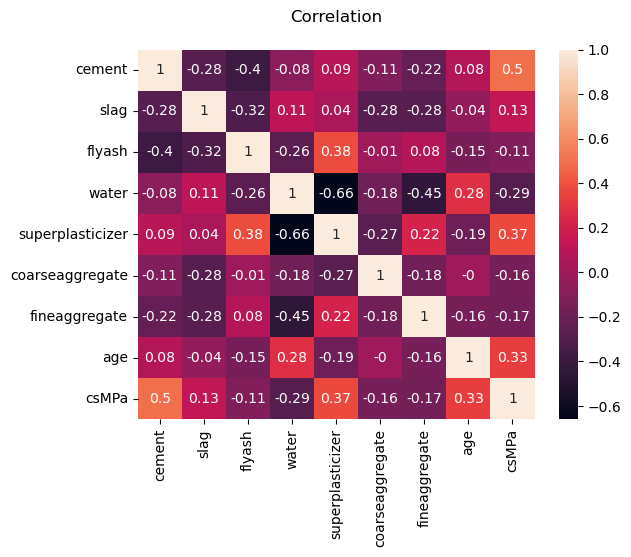

In [5]:
# build heatmap to compare correlations
sns.heatmap(df.corr().round(2),annot=True)

# set a title
plt.title('Correlation',pad=20)

# print out the map
plt.show()

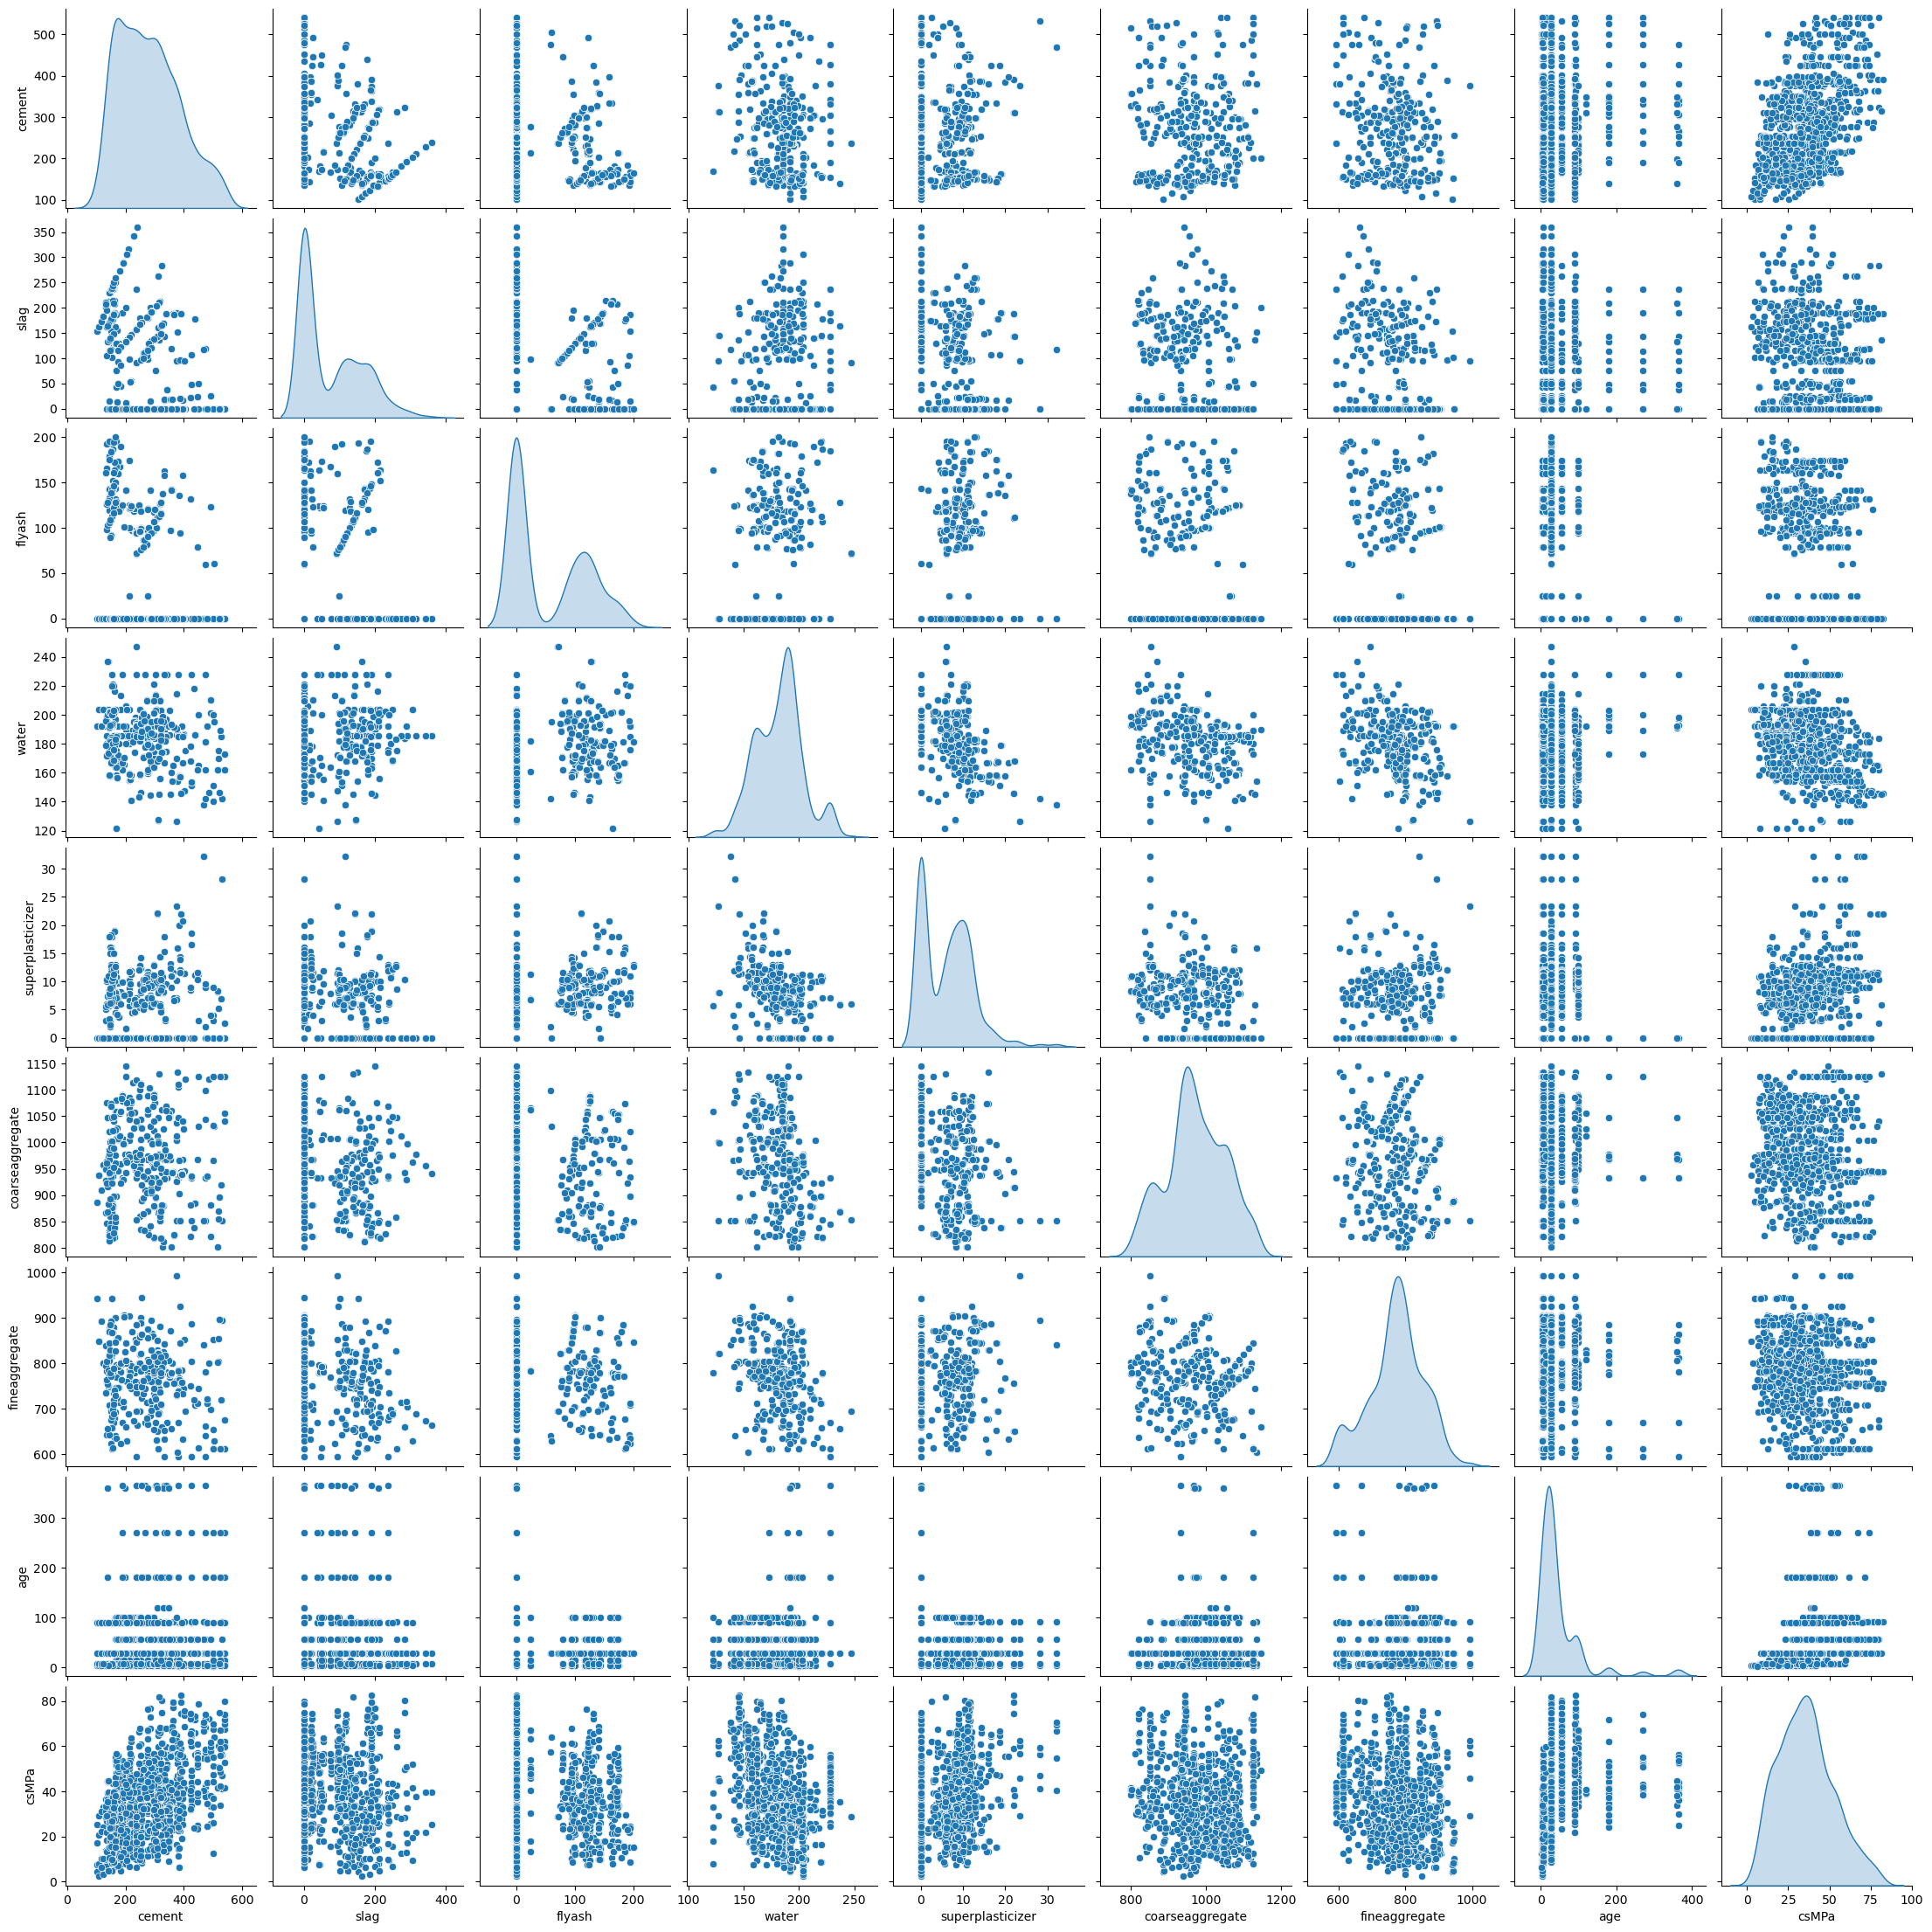

In [6]:
# explore linearity
sns.pairplot(df,diag_kind='kde')

# print the plot
plt.show()

### Data Cleaning

In [7]:
# define a function that removes outliers
def remove_outliers(data):
    q1 = np.percentile(data,25)
    q3 = np.percentile(data,75)
    iqr = q3-q1
    upper = q3+1.5*iqr
    lower = q1-1.5*iqr
    data[(data>lower)&(data<upper)]
    return data[(data>lower)&(data<upper)]

In [8]:
# create an empty data frame
df_clean = pd.DataFrame()

# populate data frame with no outliers
for name,value in df.iteritems():
    df_clean[name] = remove_outliers(value)

In [9]:
# check for missing values
df_clean.isna().sum()

cement               0
slag                 2
flyash               0
water                9
superplasticizer    10
coarseaggregate      0
fineaggregate        5
age                 59
csMPa                4
dtype: int64

In [10]:
# remove missing values
df_clean.dropna(axis=0,inplace=True)

# reset index
df_clean.reset_index(drop=True, inplace=True)

# print out the data
df_clean

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89
1,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90.0,47.03
2,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28.0,36.45
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28.0,45.85
4,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28.0,39.29
...,...,...,...,...,...,...,...,...,...
936,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28.0,44.28
937,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28.0,31.18
938,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28.0,23.70
939,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28.0,32.77


### Data Slicing

In [11]:
# split data into dependent and independent variables
X = df_clean.drop('csMPa',axis=1)
y = df_clean['csMPa']

In [12]:
# check for correlation between dependent variables
X.corr()[(X.corr()>0.3)|(X.corr()<-0.3)]

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age
cement,1.000000,NaN,-0.373968,NaN,NaN,NaN,NaN,NaN
slag,NaN,1.000000,-0.351422,NaN,NaN,NaN,NaN,NaN
flyash,-0.373968,-0.351422,1.000000,NaN,0.453972,NaN,NaN,NaN
water,NaN,NaN,NaN,1.000000,-0.641187,NaN,-0.364145,NaN
superplasticizer,NaN,NaN,0.453972,-0.641187,1.000000,NaN,NaN,NaN
coarseaggregate,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
fineaggregate,NaN,NaN,NaN,-0.364145,NaN,NaN,1.000000,NaN
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


There is moderate correlation between independent variables superplasticizer ~ flyash and superplasticizer ~ water. We may consider removing superplasticizer in future to enhance our model

### Regression Analysis

In [13]:
# import libraries for regression analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [14]:
# subset data for a test and train
features_clean = df_clean.iloc[:,:-1]
strength_clean = df_clean.iloc[:,-1]

features = df.iloc[:,:-1]
strength = df.iloc[:,-1]

In [15]:
# train data with outliers and without outliers. Use 70% of the data to train our model
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    features_clean,strength_clean,test_size=0.3,random_state=42)

# train data with outliers
X_train, X_test, y_train, y_test = train_test_split(features,strength,test_size=0.3,random_state=42)

In [16]:
# train check data
regression = LinearRegression()
regression.fit(X_train,y_train)

# print out the results
print(f'Training data r-squared:,{regression.score(X_train, y_train)}')
print(f'Test data r-squared:{regression.score(X_test, y_test)}')
print(f'Intercept:{regression.intercept_}')

Training data r-squared:,0.6196723710532999
Test data r-squared:0.5943782479239206
Intercept:-59.61868838555976


In [17]:
# train check clean data
regression = LinearRegression()
regression.fit(X_train_clean,y_train_clean)

# print out the results
print(f'Training data r-squared:,{regression.score(X_train_clean, y_train_clean)}')
print(f'Test data r-squared:{regression.score(X_test_clean, y_test_clean)}')
print(f'Intercept:{regression.intercept_}')

Training data r-squared:,0.7745552036054404
Test data r-squared:0.7550275284843797
Intercept:59.555781125016985


R squared has improved significantly in data with no outliers so we can leave the dirty data

In [18]:
# fit the model with clean data
X_incl_const = sm.add_constant(X_train_clean)

model = sm.OLS(y_train_clean,X_incl_const)

results = model.fit()

# print out summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     278.7
Date:                Sat, 25 Mar 2023   Prob (F-statistic):          3.11e-204
Time:                        18:40:20   Log-Likelihood:                -2294.2
No. Observations:                 658   AIC:                             4606.
Df Residuals:                     649   BIC:                             4647.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               59.5558     27.204  

As superplasticizer's, coarseaggregate's, and fineaggregate's p-values are over 0.05, we should exclude them from the model. What's more, superplasticizer has a high correlation with other independent variables

In [19]:
# remove columns with high p-val data
X_train_clean_no_sup_coa_fin = X_train_clean.drop(['superplasticizer','coarseaggregate','fineaggregate'],axis=1)

# print out the data frame
X_train_clean_no_sup_coa_fin

,cement,slag,flyash,water,age
830,148.0,175.0,0.0,171.0,28.0
629,203.5,305.3,0.0,203.5,3.0
292,213.5,0.0,174.2,154.6,3.0
133,222.4,0.0,96.7,189.3,14.0
591,141.3,212.0,0.0,203.5,7.0
...,...,...,...,...,...
106,379.5,151.2,0.0,153.9,56.0
270,252.3,0.0,98.8,146.3,56.0
860,153.1,145.0,113.0,178.5,28.0
435,387.0,20.0,94.0,157.0,7.0


In [20]:
# fit the model with clean data
X_incl_const_clean_no_sup_coa_fin = sm.add_constant(X_train_clean_no_sup_coa_fin)

model_no_super = sm.OLS(y_train_clean,X_incl_const_clean_no_sup_coa_fin)

results = model_no_super.fit()

# print out summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  csMPa   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     442.6
Date:                Sat, 25 Mar 2023   Prob (F-statistic):          7.98e-207
Time:                        18:40:21   Log-Likelihood:                -2297.3
No. Observations:                 658   AIC:                             4607.
Df Residuals:                     652   BIC:                             4634.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9617      3.842      6.758      0.0

### Check for multicollinearity

In [21]:
# import library
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [22]:
# calculate variance inflation factor
vif = [variance_inflation_factor(exog=X_incl_const_clean_no_sup_coa_fin.values,
                                 exog_idx=i) for i in range (X_incl_const_clean_no_sup_coa_fin.shape[1])]

# print results
pd.DataFrame({'coef_name':X_incl_const_clean_no_sup_coa_fin.columns,'vif':np.around(vif,2)})

,coef_name,vif
0,const,152.47
1,cement,1.55
2,slag,1.50
3,flyash,1.73
4,water,1.10
5,age,1.00


All the VIF values are below 5 which means there is no multicollinearity

### Predict

In [23]:
# predict values for test data
regression.predict(X_test_clean)[-5:]

array([19.50312152, 55.23800164, 21.64349995, 15.3598799 , 29.17775395])